## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model

## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [4]:
train_data = "/content/drive/MyDrive/Datasets/Driver Drowsiness/train/"
test_data = "/content/drive/MyDrive/Datasets/Driver Drowsiness/test/"

#### Generator

In [12]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical' ):
    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)


### Parameters

In [13]:
BS= 32
TS=(24,24)
train_batch= generator(train_data,shuffle=True, batch_size=BS,target_size=TS)
valid_batch= generator(test_data,shuffle=True, batch_size=BS,target_size=TS)
SPE= len(train_batch.classes)//BS
VS = len(valid_batch.classes)//BS
print(SPE,VS)

Found 1234 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
38 6


## Model Building

In [14]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',
                                                        verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,
                    monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
history = model.fit(train_batch, validation_data=valid_batch,epochs=50,steps_per_epoch=SPE ,validation_steps=VS, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8353
Epoch 1: val_accuracy improved from -inf to 0.92708, saving model to checkpoint/
38/38 [==============================] - 156s 4s/step - loss: 0.4040 - accuracy: 0.8353 - val_loss: 0.1911 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9351
Epoch 2: val_accuracy improved from 0.92708 to 0.93229, saving model to checkpoint/
38/38 [==============================] - 4s 116ms/step - loss: 0.2136 - accuracy: 0.9351 - val_loss: 0.1552 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9517
Epoch 3: val_accuracy improved from 0.93229 to 0.94271, saving model to checkpoint/
38/38 [==============================] - 4s 110ms/step - loss: 0.1317 - accuracy: 0.9517 - val_loss: 0.1310 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 4/50
38/38 [====================

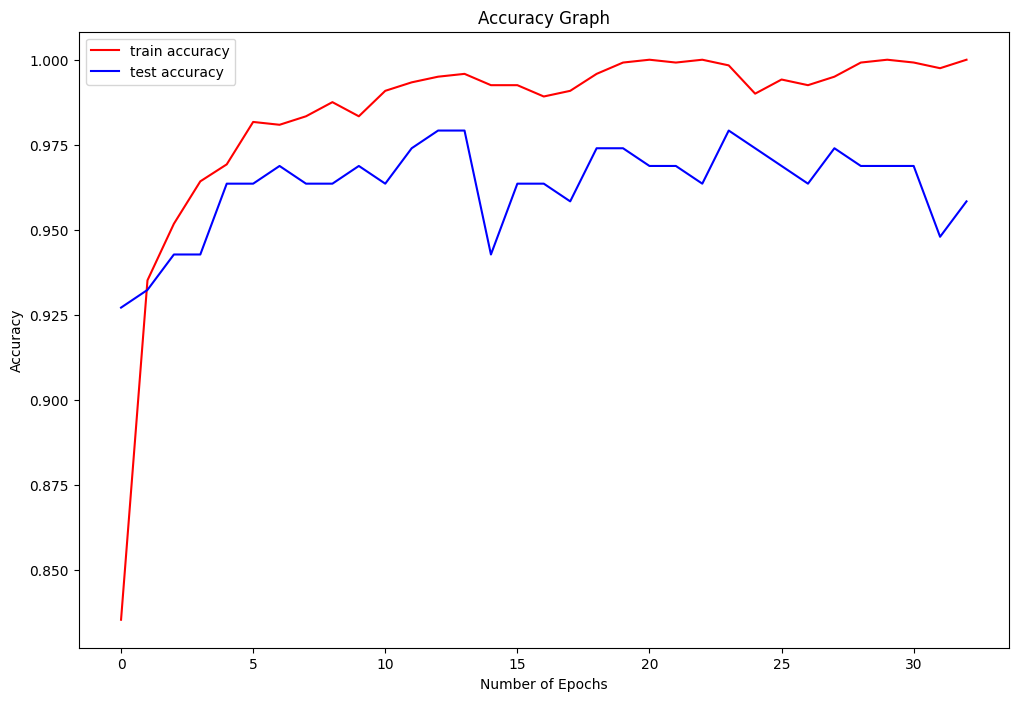

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

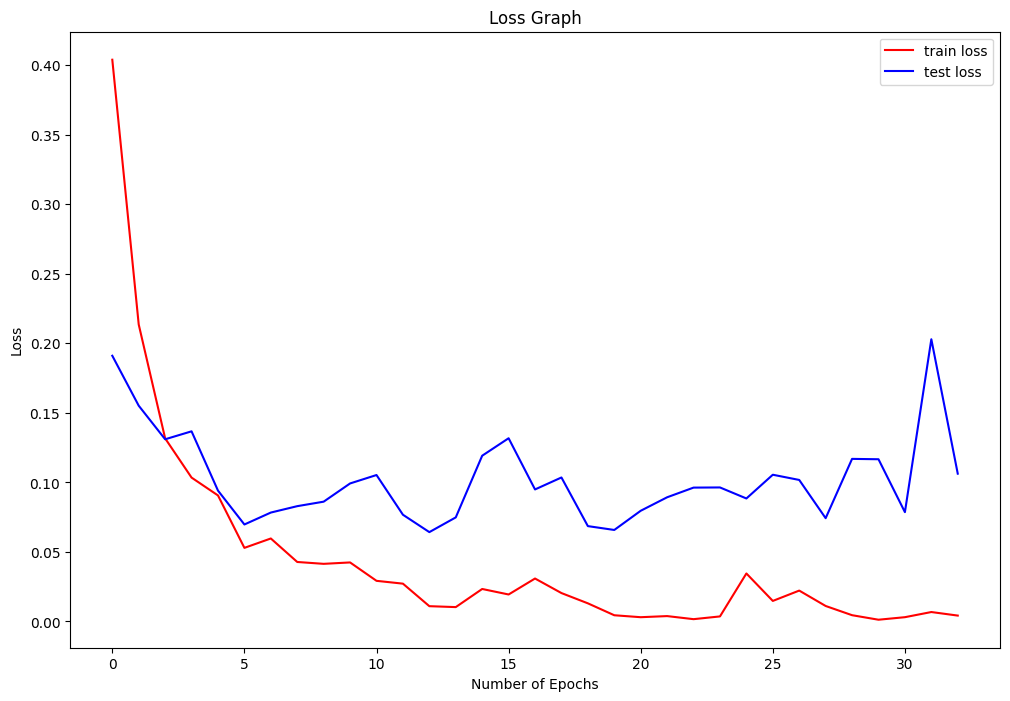

In [20]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

## Model Prediction
Now, get predictions from the model.

In [21]:
# get predictions from the model for test data
y_preds = model.predict(valid_batch)
print(y_preds.shape)

7/7 [==============================] - 1s 117ms/step
(218, 2)


In [26]:
# compute the final predicted class for each sample
y_preds_class = y_preds.argmax(axis=-1)

## Model Evaluation

In [22]:
results = model.evaluate(valid_batch)
print("Test Loss: ", results[0])
print("Test Accuracy: ", results[1])

7/7 [==============================] - 1s 82ms/step - loss: 0.0776 - accuracy: 0.9679
Test Loss:  0.0776304304599762
Test Accuracy:  0.9678899049758911


## Model Saving

In [24]:
model.save("dd_detection.h5")